# Estimate modulation transfer function of a screen

We base this on the procedure detailed in Tkačik G, Garrigan P, Ratliff C, Milčinski G, Klein JM, Seyfarth LH, et al. (2011) Natural Images from the Birthplace of the Human Eye. PLoS ONE 6(6): e20409. https://doi.org/10.1371/journal.pone.0020409.

We do this by porting over some of the MATLAB functions contained within the [UPENNNaturalImageProject](https://github.com/BrainardLab/UPENNNaturalImageProject) and [BrainardLabToolbox](https://github.com/BrainardLab/BrainardLabToolbox) github repositories. In their work, Tkačik et al use a Nikon D70 camera. We use a Nikon D90 camera, which is very similar. 

The following steps are taken:

1. Take a picture of the grating (this should be done with ISO 1600, f number 5.6, autofocus mode AF-S, and the camera set to vary the shutter speed / exposure time).

2. Convert the NEF (raw image) to PGM using `dcraw`. This should be done with `-d` and `-4` flags, so that the command is `dcraw -d -4 DSC_*.NEF`. Note that in the text of the paper above, Tkačik et al say this will produce a PPM image. The authors note that the behavior of this command depends heavily on the version of `dcraw`. They use v5.71, I use v9.21, the version found in the Ubuntu PPA as of July 20, 2018 (so dcraw was installed by calling `sudo apt install dcraw` without adding any additional PPAs). In this case, the output of the file is a PGM, because it does not separate the R, G, and B channels (without the `-d` flag, a PPM is produced, separating the three channels). However, based on the description in the text, I believe the PGM is the proper image: it does not perform any interpolation and the authors later perform the demosaicing themselves, which doesn't make sense if the channels have already been separated. (The code is inconsistent here: based on how it looks for the image, it expects a PPM file, but the function names reference PGM)

3. Demosaic the image to get the raw camera RGB values. This is done using code ported over from the BrainardLabToolbox/D70Toolbox. See the paper for more details.

4. Standardize the RGB values. While our images ar eall taken with a constant ISO and f number, the exposure may vary. To correct for this, we use the same standardizing constant that the authors use (which standardize to ISO 1000, f number 1.8, and a 1 second exposure time). Note that this assumes the camera is linear with respect to those three variables over the relevant values; we do not check this).

5. Convert the raw RGB values to luminance values. This is done first by converting the RGB values to LMS absorptions, and then converting those values to luminance. To convert from RGB to LMS, we need the spectral sensitivities of the camera's R, G, and B sensors. We use both the values provided by Tkačik et al for the D70 and the values for the D90 found at the [Camera Spectral Sensitivity Database](http://www.gujinwei.org/research/camspec/db.html). We then convert to LMS using the weighted sum presented in the paper. (Note that Tkačik et al estimate the MTF separately for the R, G, and B sensors of the camera. Since we are only interested in the MTF of greyscale images, we convert to luminance and calculate the MTF from there.)

6. Open the resulting greyscale image in Inkscape, Photoshop, or similar softare, and identify the pixel locations necessary to create masks selecting the grating and the larger full contrast bars surrounding it. To do this, estimate the pixel location at the center of the grating and some pixels to give you a radius of the grating and of the mask.

7. Perform Fourier analysis? Or just plot a slice through and see for yourself?

We do NOT:

1. subtract the dark current. we hope that having the high contrast larger bars around the grating of interest mean this isn't necessary (any reduction in contrast due to dark current will show up here as well, so we just compare the grating to these bars).

In [1]:
%matplotlib inline
import numpy as np
import imageio
import exifread
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import seaborn as sns

In [2]:
def show_im_well(img, ppi=96, zoom=1):
    ppi = float(ppi)
    fig = plt.figure(figsize=(zoom*img.shape[1]/ppi, zoom*img.shape[0]/ppi), dpi=ppi)
    bbox = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig_width, fig_height = bbox.width*fig.dpi, bbox.height*fig.dpi
    ax= fig.add_axes([0, 0, 1, 1], frameon=False, xticks=[], yticks=[])
    ax.imshow(img, cmap='gray', interpolation='none')
    return fig

Create the PGM images:

In [3]:
%%bash
dcraw -4 -d data/DSC_*.NEF

Demosaic the images. This is done in two parts:

1.  Set up mosaic mask and produce a three channel image where each channel is masked according to the sensor mosaic. The sensor mosaic the authors say is used by the D70 is
```
B  G
G  R
```
However, it appears that the sensor mosaic used by the D90 is
```
G  B
R  G
```
At least, according to [two](http://www.silios.gr/2015/06/nikon-d90-in-astrophotography-sensor-specifications/) [sources](https://sites.textiles.ncsu.edu/color-science-lab/current-research/camera-colorimetry) I found. I'm not sure the best way to check this.

2. Block average the image. This performs a weighted average on the image in 2x2 pixel blocks, weighting the red and blue pixels by 4 and the green pixels by 2 to make up for the fact that the green pixels are over-represented on the sensor mosaic.

In [4]:
with open('data/DSC_0004.NEF', 'rb') as f:
    tags = exifread.process_file(f)
# The f number and exposure time are Ratio and we want them as floats
metadata = {'f_number': tags['EXIF FNumber'].values[0].num / float(tags['EXIF FNumber'].values[0].den), 'iso': tags['EXIF ISOSpeedRatings'].values[0],
            'exposure_time': tags['EXIF ExposureTime'].values[0].num / float(tags['EXIF ExposureTime'].values[0].den), 'focus_mode': tags['MakerNote FocusMode'].values.strip()}

im = imageio.imread('data/DSC_0004.pgm').astype(np.double)
im = im

In [5]:
# We "pythonify" the conventions in the Tkačik et al paper: R=0, G=1, B=2
D90_BAYER = np.array([[1, 2], [0, 1]])
def create_mosaic_mask(bayer_mosaic, img_shape):
    """create mask based on Bayer mosaic of the camera
    
    this is based on the Brainard's lab's SimToolbox's SimCreateMask.m"""
    # First create a small kernel representing the RGB mosaic pattern
    kernels = np.zeros((len(np.unique(bayer_mosaic)), bayer_mosaic.shape[0], bayer_mosaic.shape[1]))
    for i in range(bayer_mosaic.shape[0]):
        for j in range(bayer_mosaic.shape[1]):
            kernels[bayer_mosaic[i, j], i, j] = 1

    # Then repeat the kernel to build a mask to the size  of the image
    mask = []
    for n in range(kernels.shape[0]):
        mask.append(np.tile(kernels[n], (int(np.ceil(img_shape[0] / float(bayer_mosaic.shape[0]))+1), int(np.ceil(img_shape[1] / float(bayer_mosaic.shape[1]))+1))))
    mask = np.dstack(mask).transpose((2, 0, 1))
    if mask.shape[1] < img_shape[0] or mask.shape[2] < img_shape[1]:
        raise Exception('Logic error in computation of mask size')
    mask = mask[:, :img_shape[0], :img_shape[1]]
    return mask, kernels

def block_avg(img):
    """block average the image
    
    note that the image you pass must be 2d"""
    assert im.ndim == 2, "Can only block average 2d images!"
    avged = 0.25*(img[1:,:-1] + img[:-1, 1:] + img[:-1,:-1] + img[1:,1:])
    return avged[::2, ::2]    

In [6]:
mask, kernels = create_mosaic_mask(D90_BAYER, im.shape)
raw_demosaiced_image = np.zeros(mask.shape)
# demosaic the image
for i in range(3):
    raw_demosaiced_image[i] = im * mask[i]

In [7]:
# and block average it
demosaiced_image = np.zeros((3, mask.shape[1]//2, mask.shape[2]//2))
for i, w in zip(range(3), [4, 2, 4]):
    demosaiced_image[i] = w*block_avg(raw_demosaiced_image[i])

Now we standardize the RGB values. I'm not sure this step is necessary for what we do, but may as well. This assumes that the raw RGB values of the camera we're using is linear with respect to exposure time, aperture value, and ISO, as Tkačik et al found for their Nikon D70 (see figures 6, 7, and 8). We then multiply by a scaling constant to normalize the RGB values of images taken with different settings. For our use, the ISO and aperture value will be constant, but the exposure time may vary. The constant we use (from equation 1 in the Tkačik et al) is:

$\frac{1000}{ISO}*(\frac{f}{1.8})^2*\frac{1s}{exposure}$

In Tkačik et al, they multiply this number by $raw\_RGB - dark\_current$, but here we do not subtract the dark current and so only multiply it by $raw\_RGB$

In [8]:
def standardizing_constant(iso, f_number, exposure_time, **kwargs):
    """calculate the constant to convert raw to standard RGB values
    
    note that kwargs is ignored, we just use it so we can swallow the extra keys from the metadata dict"""
    return (1000. / iso) * (f_number / 1.8)**2 * (1. / exposure_time)

In [9]:
standard_RGB = demosaiced_image * standardizing_constant(**metadata)

Now we convert the RGB values to LMS and then to luminance. To convert from RGB to LMS, we can either use the conversion matrix given by the paper (this is the `M_RGBToLMS` field in the `Cam_Cal` struct for their standard D70 camera, which can be found in the Brainard lab's [D70 Toolbox](https://github.com/BrainardLab/BrainardLabToolbox/blob/master/D70Toolbox/CameraData/StandardD70Data.mat)):
```
   1.0e-07 *

    0.1267    0.2467   -0.0450
    0.0327    0.2904   -0.0299
    0.0038   -0.0292    0.2425
```

or grab the RGB sensitivites from the [camspec database](http://www.gujinwei.org/research/camspec/db.html) (`S_RGB`) and the cone fundamentals from [here](http://www.cvrl.org/cones.htm) (2 degree fundamentals, linear energy, 5 nm, csv; `S_LMS`) and compute them yourself. This requires restricting `S_LMS` to the wavelengths between 400 and above 720, which is what `S_RGB` cover, and dropping some of the data, because `S_LMS` is sampled in 5nm increments, while `S_RGB` is sampled in 10nm ones. You then simply regress one onto the other. Both files are included in the data directory of this project

for LMS to luminance, use the one provided by the paper (this is also the `M_LMSToLum` field in the `Cam_Cal` struct):
```
433.9441  275.8200   -0.0935
```

Both of the matrices get multiplied by the observed values from the right (so the pixel values should be 3xN)

In [10]:
# input the paper's conversion matrices
paper_rgb_to_lms = 1e-7 * np.array([[.1267, .2467, -.0450], [.0327, .2904, -.0299], [.0038, -.0292, .2425]])
lms_to_lum = np.array([433.9441, 275.82, -.0935])

Here, we simply load in the 2 degree cone fundamentals, drop the values we don't need, and turn this into a matrix}

In [11]:
s_lms = pd.read_csv('data/linss2_10e_5.csv', header=None, names=['wavelength', 'l_sens', 'm_sens', 's_sens'])
s_lms = s_lms.fillna(0)
s_lms = s_lms[(s_lms.wavelength>=400) & (s_lms.wavelength<=720)][::2].reset_index(drop=True)
s_lms_mat = s_lms[['l_sens', 'm_sens', 's_sens']].values

Because of how `camspec_database.txt` is formatted, this is slightly more complicated. The is many lines long, with the following pattern:

```
camera_name_1
r_sens_400   r_sens_410   ...   r_sens_720
g_sens_400   g_sens_410   ...   g_sens_720
b_sens_400   b_sens_410   ...   b_sens_720
camera_name_2
...
```

where those three spaces in the sensitivity lines represent a tab. We therefore read in the file line by line, expecting the above pattern, reading the camera names and the three sensitivities into different arrays. We also construct the wavelengths array, using the values shown in the plot on the website. We then tile the wavelengths and repeat the camera names so that all arrays are the same length, which allows us to create a nice Dataframe with all this data. Finally, we select only the camera we're interested in and convert the sensitivites to a matrix.

In [12]:
with open('data/camspec_database.txt') as f:
    tmp = f.readlines()

# This file has the name of the camera on the 1st line, then 3 lines detailing the R, G, and B sensitivities, before repeating with the next camera
# therefore, every 4th line contains the name of the camera, the others are sensitivities
wavelengths = np.arange(400, 721, 10)
n_wavelengths = len(wavelengths)
cameras = []
r_sens = []
g_sens = []
b_sens = []
for i, t in enumerate(tmp):
    t = t.strip().split('\t')
    if i % 4 == 0:
        cameras.append(t)
    elif i % 4 == 1:
        r_sens.append([float(j) for j in t])
    elif i % 4 == 2:
        g_sens.append([float(j) for j in t])
    elif i % 4 == 3:
        b_sens.append([float(j) for j in t])        

wavelengths = np.tile(wavelengths, len(cameras))
cameras = np.repeat(np.array(cameras).flatten(), n_wavelengths)
r_sens = np.array(r_sens).flatten()
g_sens = np.array(g_sens).flatten()    
b_sens = np.array(b_sens).flatten()    

s_rgb = pd.DataFrame({'camera': cameras, 'r_sens': r_sens, 'g_sens': g_sens, 'b_sens': b_sens, 'wavelength': wavelengths})
s_rgb = s_rgb[s_rgb.camera=='Nikon D90']
s_rgb_mat = s_rgb[['r_sens', 'g_sens', 'b_sens']].values

With these two matrices, we can regress one onto the other to get the conversion matrix from RGB to LMS. 

When comparing to the one found in the paper, we notice that they differ by orders of magnitude. This is because the sensitivities given in the camspec database are normalized, whereas the sensitivities used in the paper are not. Our RGB values are also un-normalized. To correct for this, we just find the scalar factor that best matches the two matrices and multiply our calculated conversion matrix by this number.

In [13]:
wavelengths = np.arange(400, 721, 10)
calc_rgb_to_lms = np.linalg.lstsq(s_rgb_mat, s_lms_mat)[0].transpose()
print("Calculated conversion matrix:\n%s"%calc_rgb_to_lms)
print("\nPaper's conversion matrix:\n%s"%paper_rgb_to_lms)

Calculated conversion matrix:
[[ 1.09135851  0.90878799 -0.24303644]
 [ 0.26715919  1.0550696  -0.14562975]
 [ 0.05900538 -0.1869463   0.89910699]]

Paper's conversion matrix:
[[ 1.267e-08  2.467e-08 -4.500e-09]
 [ 3.270e-09  2.904e-08 -2.990e-09]
 [ 3.800e-10 -2.920e-09  2.425e-08]]


/home/billbrod/anaconda2/envs/calibration/lib/python3.6/site-packages/ipykernel/__main__.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


In [14]:
def find_scaling_factor(x):
    return (paper_rgb_to_lms - x*calc_rgb_to_lms).flatten()

res = optimize.least_squares(find_scaling_factor, 1)

To double-check that the conversion matrix is correct, we recreate figure 9 from the paper. Note that the first subplot is different, because we're using the camera sensitivities from the camspec database, but that the final subplot looks very similar, which tells us this conversion matrix works well.

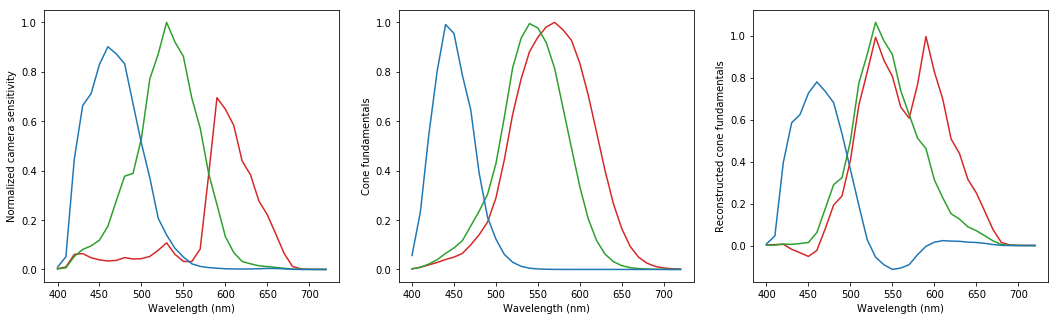

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
reconstructed_s_lms = np.matmul(calc_rgb_to_lms, s_rgb_mat.transpose()).transpose()
for ax, data, ylabel in zip(axes, [s_rgb_mat, s_lms_mat, reconstructed_s_lms], ['Normalized camera sensitivity', 'Cone fundamentals', 'Reconstructed cone fundamentals']):
    for i in range(3):
        ax.plot(wavelengths, data[:, i], ['C3', 'C2', 'C0'][i])
    ax.set_xlabel('Wavelength (nm)')
    ax.set_ylabel(ylabel)

In [16]:
lum_image = np.dot(lms_to_lum, np.matmul(paper_rgb_to_lms, standard_RGB.transpose(1,0,2)))
imageio.imsave('test_paper.png', lum_image)

In [17]:
lum_image = np.dot(lms_to_lum, np.matmul(res.x * calc_rgb_to_lms, standard_RGB.transpose(1,0,2)))
imageio.imsave('test_calc.png', lum_image)

In [18]:
pts_dict = {'circle_ctr': (1130, lum_image.shape[0] - 760), 
            'grating_edge': [(1135, lum_image.shape[0]-1087), (780, lum_image.shape[0]-750), (1137, lum_image.shape[0]-390), (1378, lum_image.shape[0]-490), (1310, lum_image.shape[0]-437), 
                             (1063, lum_image.shape[0]-397), (1012, lum_image.shape[0]-1066), (1252, lum_image.shape[0]-1065), (1336, lum_image.shape[0]-1024)],
            'white_edge': [(1585, lum_image.shape[0]-542), (1142, lum_image.shape[0]-243), (642,lum_image.shape[0]-713), (1131, lum_image.shape[0]-1226)],
            'black_edge': [(1143, lum_image.shape[0] -1359), (1764, lum_image.shape[0] -745), (504, lum_image.shape[0]-762), (1135, lum_image.shape[0]-98)]}

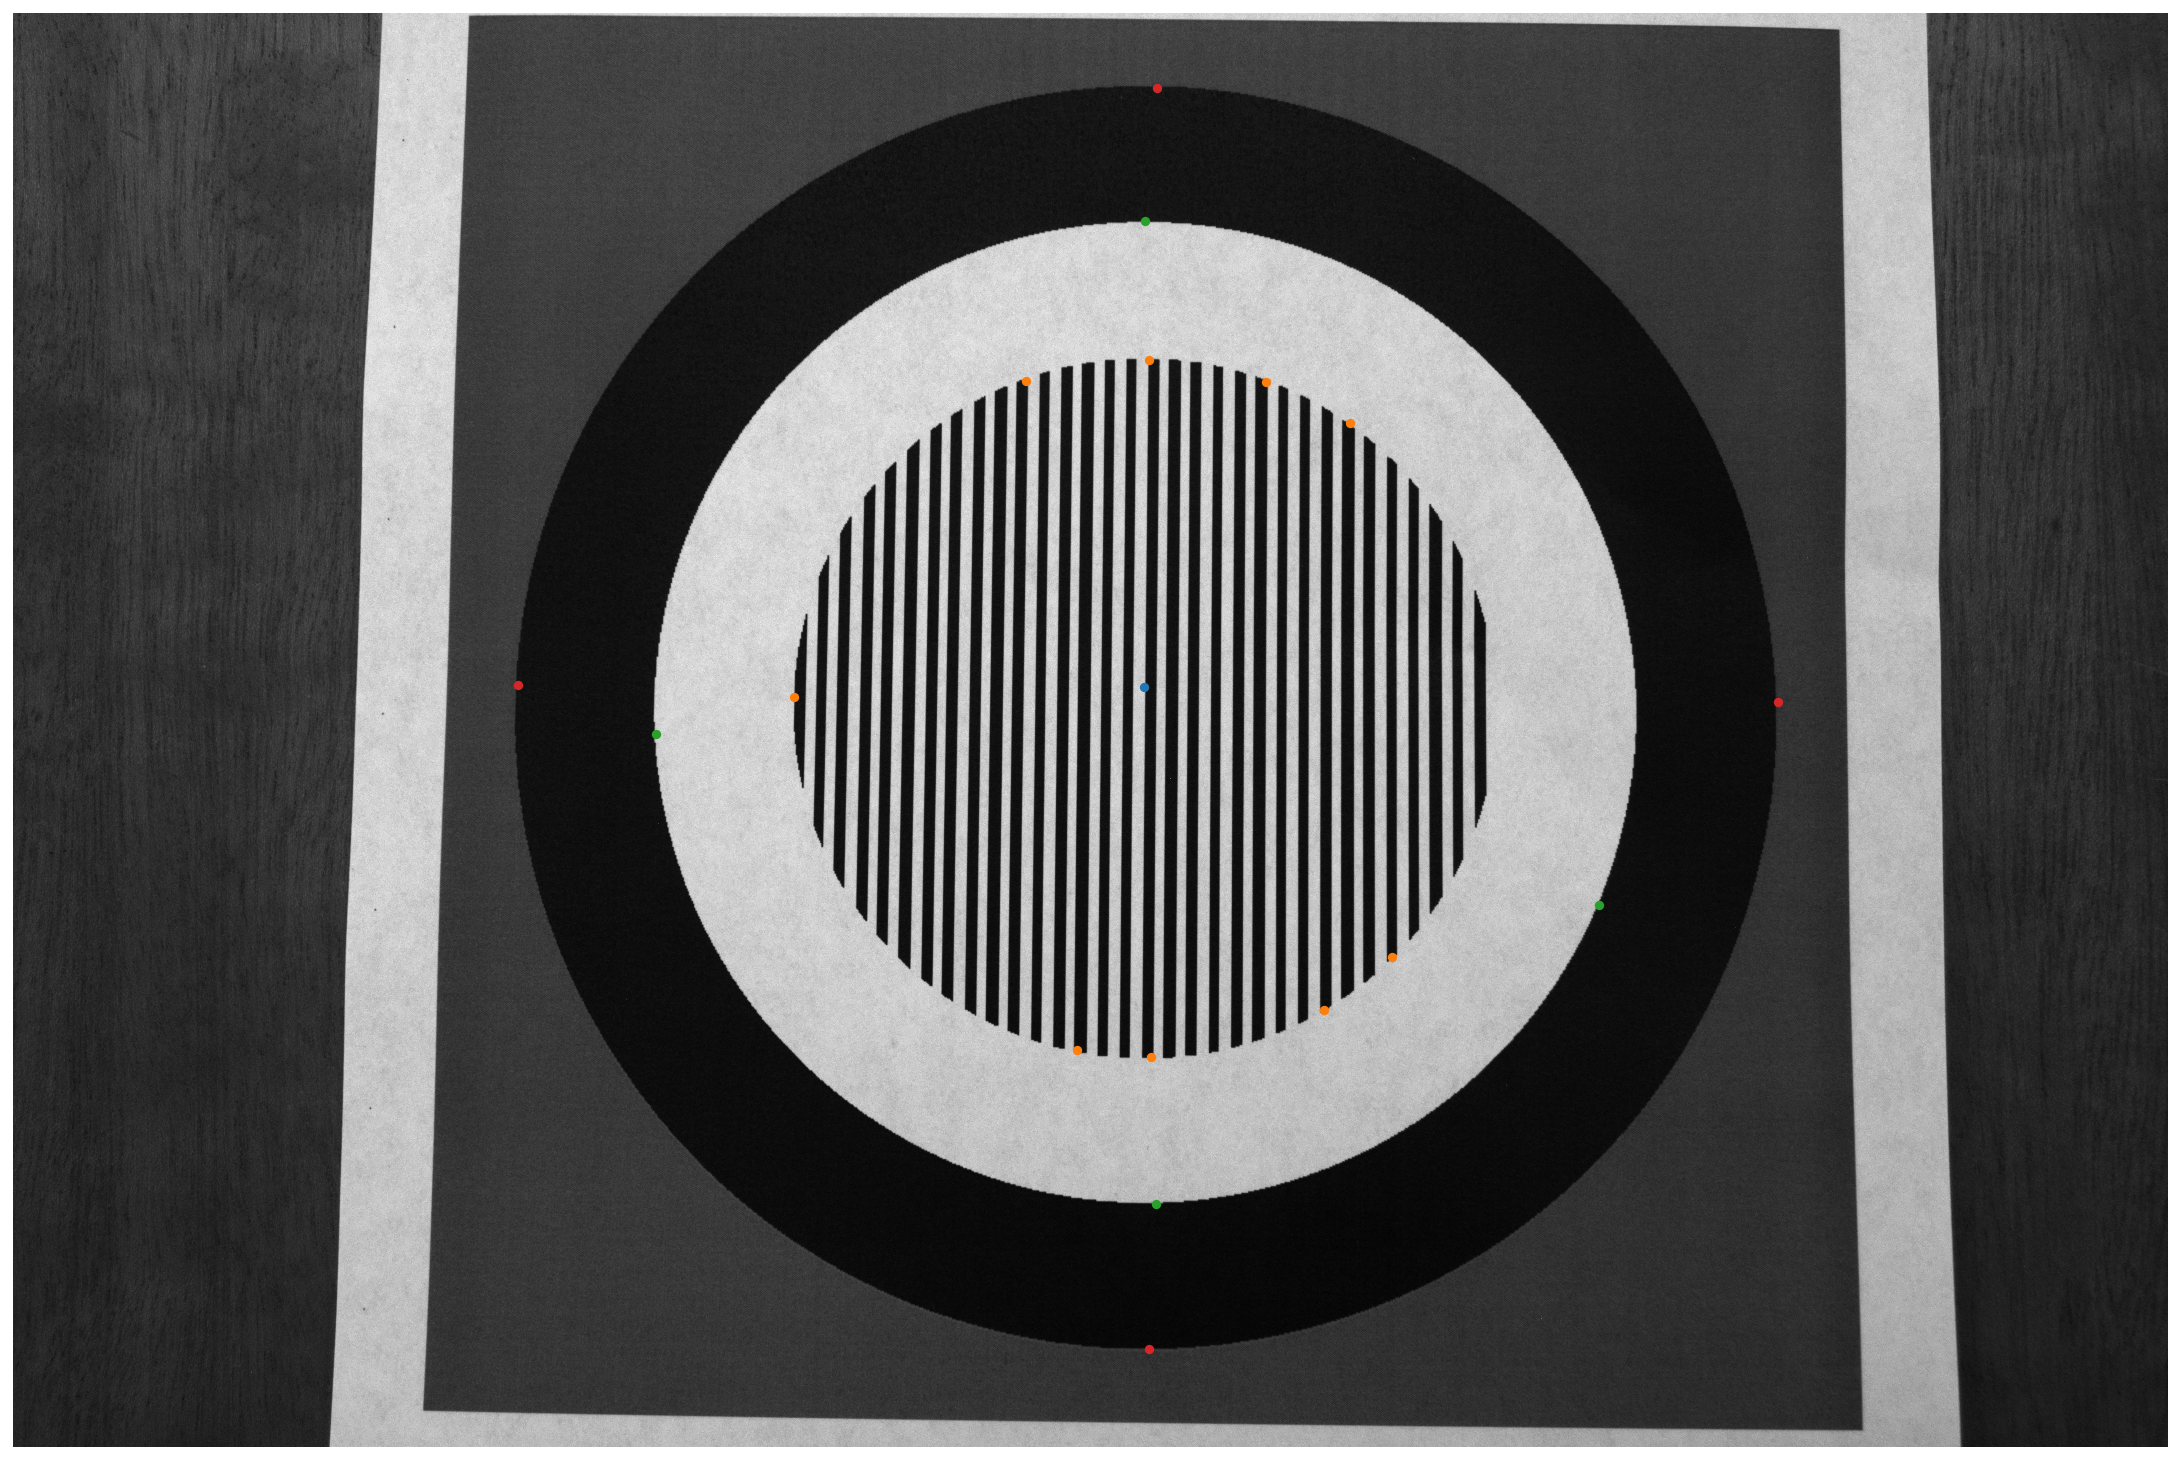

In [19]:
fig = show_im_well(lum_image)
for pts in pts_dict.values():
    pts = np.array(pts).T
    fig.axes[0].scatter(*pts)

Optimize for this: take all the points given along the edge and then find the r, x0, y0 that minimize the value of $(x-x0)^2+(y-y0)^2-r^2$

In [20]:
def find_circle(X, grating_edge, white_edge, black_edge):
    # because of how scipy.optimize works, all the paramters to optimize have to be included in one argument, X
    x0, y0, r_grating, border_ring_width = X
    vals = []
    for x, y in grating_edge:
        vals.append((x0 - x)**2 + (y0 - y)**2 - r_grating**2)
    for x, y in white_edge:
        vals.append((x0 - x)**2 + (y0 - y)**2 - (r_grating + border_ring_width)**2)
    for x, y in black_edge:
        vals.append((x0 - x)**2 + (y0 - y)**2 - (r_grating + 2*border_ring_width)**2)
    return vals

def get_initial_guess(circle_ctr, grating_edge, white_edge, black_edge):
    rs = []
    for edge in [grating_edge, white_edge, black_edge]:
        if type(edge) is list:
            edge = edge[0]
        rs.append(np.sqrt((circle_ctr[0] - edge[0])**2 + (circle_ctr[1]-edge[1])**2))
    return circle_ctr[0], circle_ctr[1], rs[0], np.mean(rs[1:]) - rs[0]

res= optimize.least_squares(find_circle, get_initial_guess(**pts_dict), args=(pts_dict['grating_edge'], pts_dict['white_edge'], pts_dict['black_edge']))
x0, y0, r_grating, border_ring_width = res.x

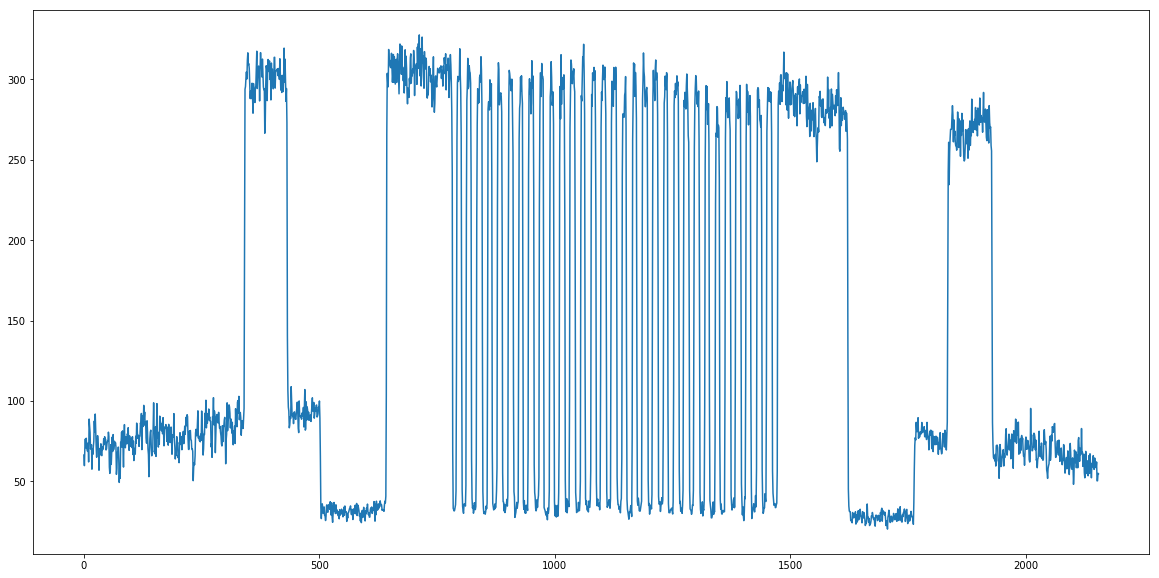

In [21]:
plt.figure(figsize=(20,10))
plt.plot(lum_image[int(lum_image.shape[0]-y0), :])

In [22]:
def create_circle_masks(img_shape, circle_ctr_x, circle_ctr_y, grating_radius, border_ring_width):
    """create circle masks to do FFT on
    
    circle_ctr must be a single tuple, grating_edge and border_edge can be tuple or list of tuples
    """
    xgrid, ygrid = np.meshgrid(range(img_shape[1]), range(img_shape[0]))
    grating_mask = np.zeros(img_shape)
    grating_mask[(xgrid - circle_ctr_x)**2 + (ygrid - circle_ctr_y)**2 <= grating_radius**2] = 1
    white_mask = np.zeros(img_shape)
    white_mask[(xgrid - circle_ctr_x)**2 + (ygrid - circle_ctr_y)**2 <= (grating_radius+border_ring_width)**2] = 1
    white_mask -= grating_mask
    black_mask = np.zeros(img_shape)
    black_mask[(xgrid - circle_ctr_x)**2 + (ygrid - circle_ctr_y)**2 <= (grating_radius+2*border_ring_width)**2] = 1
    black_mask -= (grating_mask + white_mask)
    return grating_mask.astype(bool), white_mask.astype(bool), black_mask.astype(bool)

def create_circle_outlines(img_shape, circle_ctr_x, circle_ctr_y, grating_radius, border_ring_width, edge_tol=10):
    """create circle masks to do FFT on
    
    circle_ctr must be a single tuple, grating_edge and border_edge can be tuple or list of tuples
    """
    xgrid, ygrid = np.meshgrid(range(img_shape[1]), range(img_shape[0]))
    grating_mask = np.zeros(img_shape)
    grating_mask[np.abs((xgrid - circle_ctr_x)**2 + (ygrid - circle_ctr_y)**2 - grating_radius**2) < edge_tol] = 1
    white_mask = np.zeros(img_shape)
    white_mask[np.abs((xgrid - circle_ctr_x)**2 + (ygrid - circle_ctr_y)**2 - (grating_radius+border_ring_width)**2) < edge_tol] = 1
    black_mask = np.zeros(img_shape)
    black_mask[np.abs((xgrid - circle_ctr_x)**2 + (ygrid - circle_ctr_y)**2 - (grating_radius+2*border_ring_width)**2) < edge_tol] = 1
    return np.where(grating_mask), np.where(white_mask), np.where(black_mask)

In [23]:
grating_mask, white_mask, black_mask = create_circle_masks(lum_image.shape, *res.x)
grating_pts, white_pts, black_pts = create_circle_outlines(lum_image.shape, *res.x, 20)

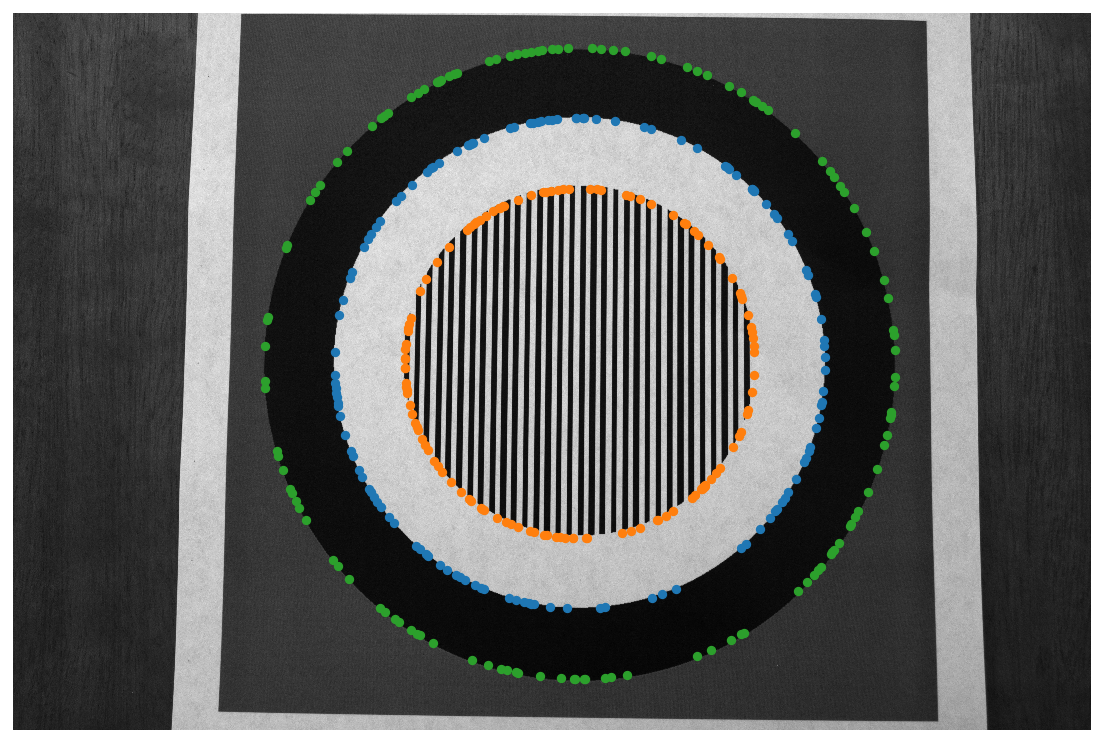

In [24]:
fig=show_im_well(lum_image, zoom=.5)
for p in [white_pts, grating_pts, black_pts]:
    plt.scatter(p[1], p[0])

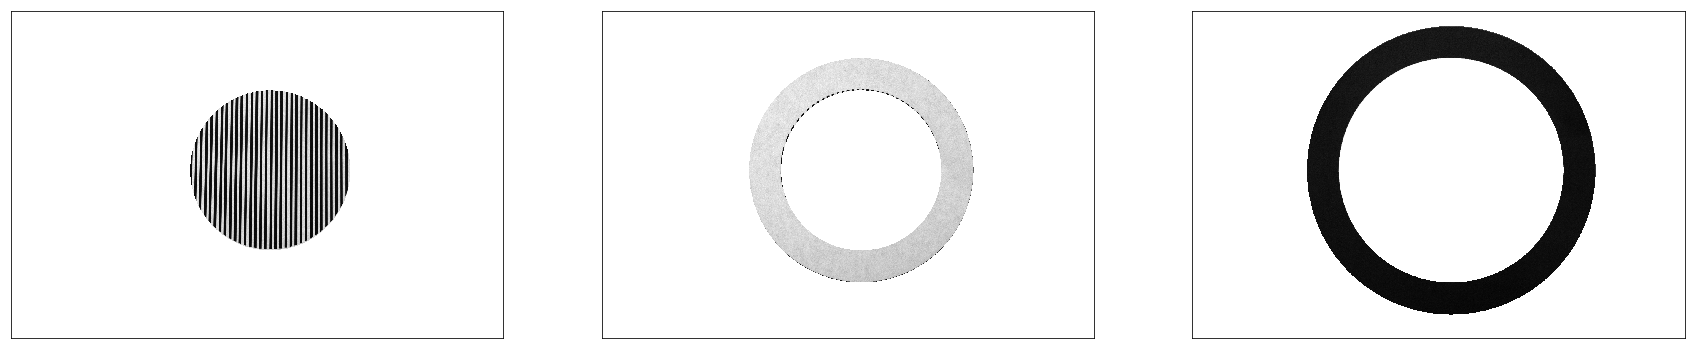

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(30,10))
for ax, mask in zip(axes, [grating_mask, white_mask, black_mask]):
    tmp = lum_image*mask
    tmp[tmp==0] = np.nan
    ax.imshow(tmp, cmap='gray', interpolation='none')
    ax.set(xticks=[], yticks=[])

In [26]:
white_ring = (lum_image*white_mask)[int(y0), :int(x0)]
black_ring = (lum_image*black_mask)[int(y0), :int(x0)]
ring = white_ring + black_ring
ring[ring==0] = np.nan
ring = ring[~np.isnan(ring)]

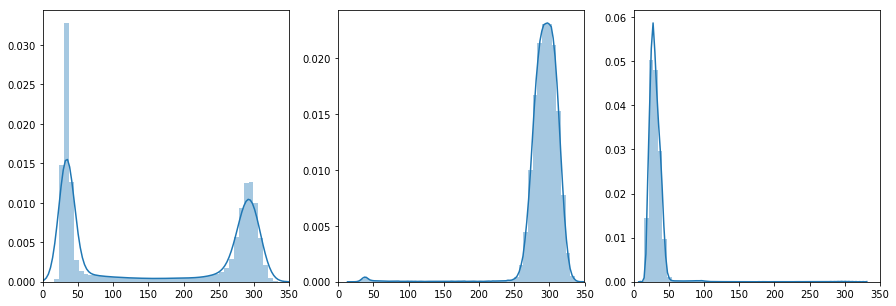

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, mask in zip(axes, [grating_mask, white_mask, black_mask]):
    sns.distplot(lum_image[mask], ax=ax)
    ax.set_xlim(0, lum_image[white_mask].max())

In [28]:
grating = lum_image * grating_mask
grating[grating==0] = np.nan
grating_1d = np.nanmean(grating, 0)

/home/billbrod/anaconda2/envs/calibration/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()


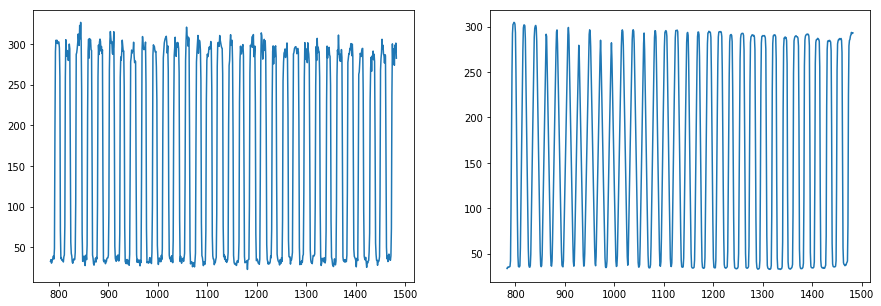

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(grating[int(y0), :])
axes[1].plot(grating_1d)

In [30]:
grating_1d = grating_1d[~np.isnan(grating_1d)]

Implemented that phase shift thingy and see if that helps

In [41]:
def fft_stuff(grating_1d):
    freqs = np.fft.fftshift(np.fft.fftfreq(len(grating_1d),))
    fft = np.fft.fftshift(np.fft.fft(grating_1d / grating_1d.mean()))
    fft /= len(fft)

    power = fft * np.conj(fft)
    amp = np.sqrt(power)

    return power, amp, fft, freqs
    
    
def get_contrast(orig_grating_1d, n_phases=20):

    amps = {}
    for phase in range(n_phases):
        power, amp, fft, freqs = fft_stuff(orig_grating_1d[phase:])
        power[freqs==0] = 0
        amps[phase] = np.max(amp[np.argwhere(power==np.max(power))])
        
    max_phase = max(amps, key=lambda key: amps[key])
    power, amp, fft, freqs = fft_stuff(orig_grating_1d[max_phase:])
    
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    for ax, data, title in zip(axes, [fft, power, amp], ['fft', 'power', 'amplitude']):
        # right, plotting the fft doesn't make a lot of sense because it's complex-valued
        ax.stem(freqs[freqs>=0], data[freqs>=0])
        ax.set_title(title)

    power[freqs==0] = 0
    power_argmax = np.argwhere(power==np.max(power))

    print("Max phase crop: %s"%max_phase)
    print("Max frequencies:\n %s\n"%freqs[power_argmax])
    print("Amplitude at max freqs:\n %s\n"%amp[power_argmax])

    filtered_fft = np.zeros(len(fft), dtype=np.complex)
    filtered_fft[np.argwhere(freqs==0)] = fft[np.argwhere(freqs==0)]
    filtered_fft[power_argmax] = fft[power_argmax]

    filtered_grating_1d = np.abs(np.fft.ifft(np.fft.ifftshift(filtered_fft)) * len(fft))
    contrast = (np.max(filtered_grating_1d) - np.min(filtered_grating_1d)) / (np.max(filtered_grating_1d) + np.min(filtered_grating_1d))
    
    return filtered_grating_1d, contrast

/home/billbrod/anaconda2/envs/calibration/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Max phase crop: 19
Max frequencies:
 [[-0.04552129]
 [ 0.04552129]]

Amplitude at max freqs:
 [[0.43282843+0.j]
 [0.43282843+0.j]]

Contrast: 0.8656562731168987


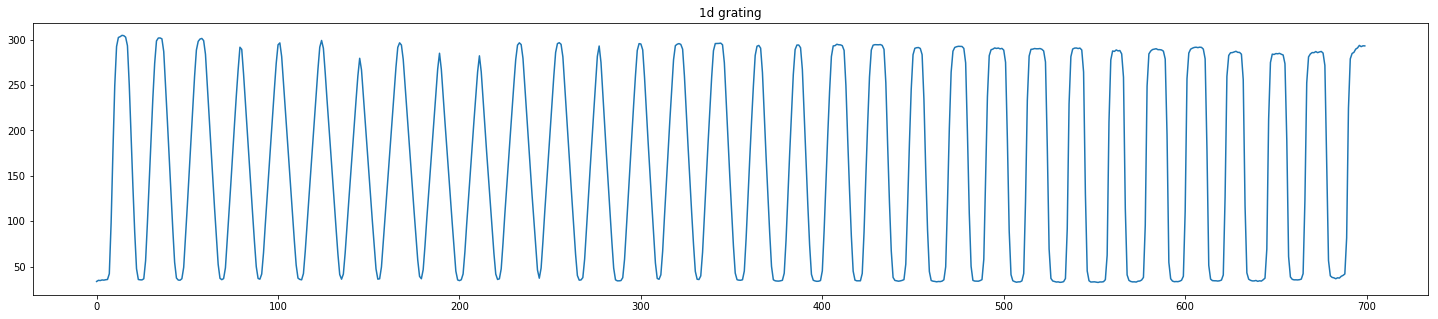

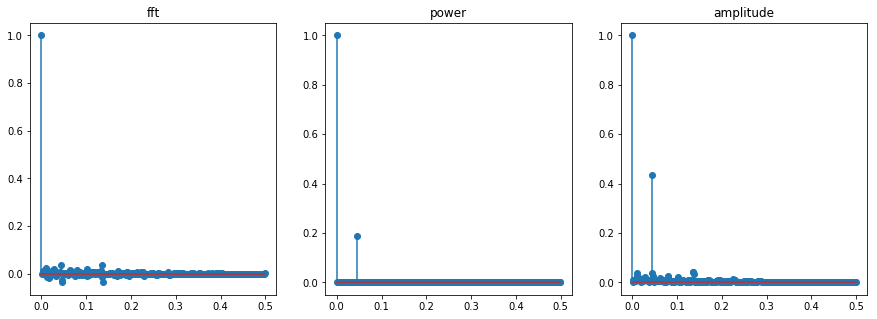

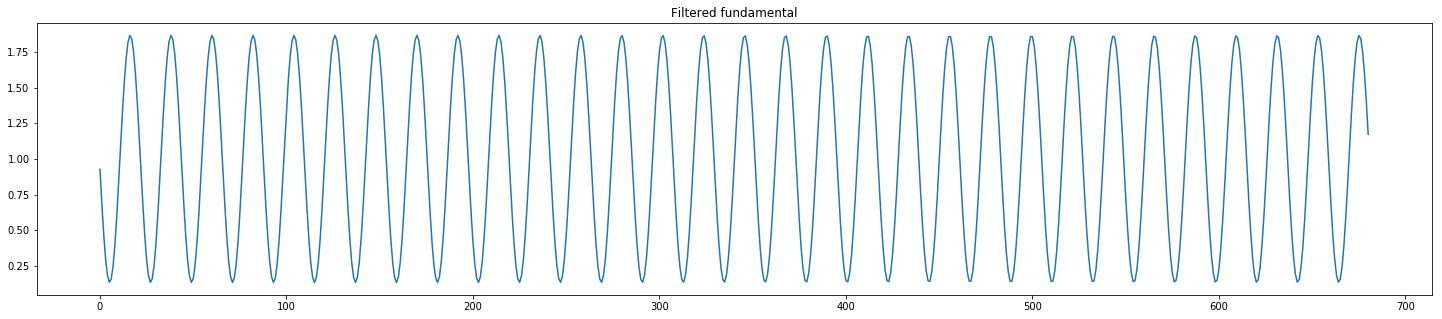

In [42]:
plt.figure(figsize=(25, 5))
plt.plot(grating_1d)
plt.title('1d grating')

fg, c = get_contrast(grating_1d)

plt.figure(figsize=(25, 5))
plt.plot(fg)
plt.title('Filtered fundamental')
print("Contrast: %s"%c)

/home/billbrod/anaconda2/envs/calibration/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Max phase crop: 0
Max frequencies:
 [[-0.00357143]
 [ 0.00357143]]

Amplitude at max freqs:
 [[0.51644579+0.j]
 [0.51644579+0.j]]

Contrast: 0.9991920372456814


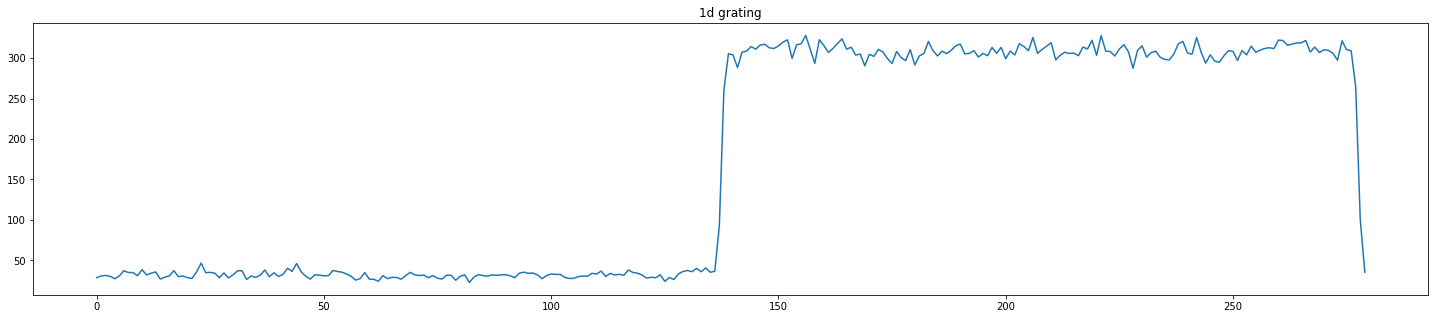

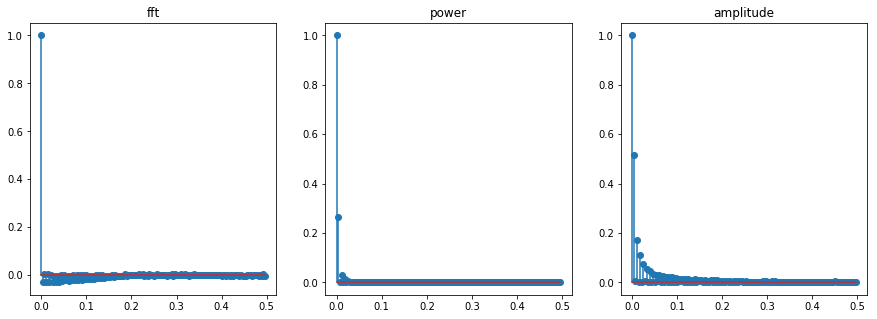

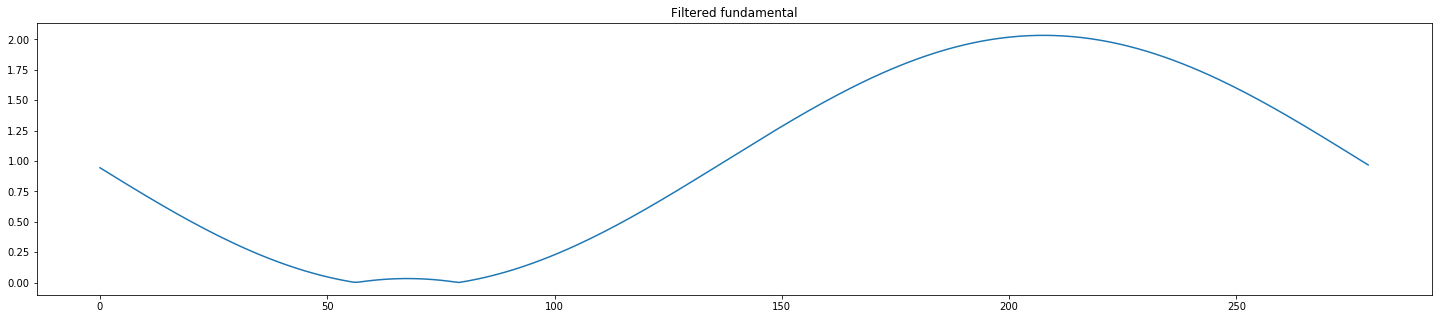

In [45]:
plt.figure(figsize=(25, 5))
plt.plot(ring)
plt.title('1d grating')

fg, c = get_contrast(ring)

plt.figure(figsize=(25, 5))
plt.plot(fg)
plt.title('Filtered fundamental')
print("Contrast: %s"%c)